In [1]:
import numpy as np
from scipy import signal
import numbers
import errno
import os
import configparser
import sys
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim 
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('..')

import matplotlib.pyplot as plt

In [2]:
def reshape_dataset_to_tensor(X, y=None, structure='static'):
    """numpyからtensorへの変換
    """
    X_tensor = torch.from_numpy(X).float()
    if structure == 'dynamic': # 時系列を考慮する変換
        X_tensor = torch.unsqueeze(X_tensor, dim=1)
    if y is not None:
        y_tensor = torch.from_numpy(y).long()
        return TensorDataset(X_tensor, y_tensor)
    else:
        return X_tensor
    
def normalize_train_data(X, type='norm', dim='whole'):
    """訓練データを正規化（標準化）する処理
    """
    stats = {}

    if dim == 'whole':
        stats['max'] = np.max(X)
        stats['mean'] = np.mean(X)
        stats['std'] = np.std(X)
    elif dim == 'each':
        stats['max'] = np.max(X, axis=0)
        stats['mean'] = np.mean(X, axis=0)
        stats['std'] = np.std(X, axis=0)

    if type == 'norm':
        X = X / stats['max']
    elif type == 'standard':
        X = (X - stats['mean']) / stats['std']
    
    return X, stats

In [3]:
n_channel = 4
n_class = 6
n_trial = 10
time_width = 45
down_sampling_rate = 10

In [4]:
stacked_data = np.empty((0, time_width, n_channel))
class_label = np.empty(0)
subject_label = np.empty(0)
select_subject = [0,1,2,3,4]
for s in select_subject:
    fname = f'./data/furui_lab/extracted/1.0Hz/sub{s+1}/'
    for c in range(n_class):
        # print(f'sub : {s+1} class_label : {c+1}')
        # stacked_data_trial = np.empty((0, time_width, n_channel))
        for t in range(n_trial):
            read_data = np.loadtxt(f'{fname}class{c+1}trial{t+1}.csv', usecols= [0,1,2,3],delimiter=',')
            # read_data = read_data[::down_sampling_rate]
            read_data = read_data.reshape(-1, time_width, n_channel)
            read_class_label = np.full(len(read_data),c)
            read_subject_label = np.full(len(read_data),s)
            
            stacked_data = np.vstack([stacked_data, read_data])
            class_label = np.hstack([class_label, read_class_label])
            subject_label = np.hstack([subject_label, read_subject_label])
        #     subject_label = np.hstack([subject_label, read_subject_label])

        #     # print(f'trial : {t+1} len : {len(read_data)}')

        #     stacked_data_trial = np.vstack([stacked_data_trial, read_data])

        # # stacked_data_trial = np.copy(stacked_data_trial[1:])

        # stacked_data = np.vstack([stacked_data, stacked_data_trial])
        # class_label = np.hstack([class_label, np.full(len(stacked_data_trial), c, dtype='int8')])
        # subject_label = np.hstack([subject_label, np.full(len(stacked_data_trial), s, dtype='int8')])
# stacked_data = stacked_data[1:]
# class_label = class_label[1:]
# subject_label = subject_label[1:]


In [5]:
print(stacked_data[0][1])
X, _ = normalize_train_data(stacked_data, 'norm', 'each')
print(X[0][1])
train_dataset = reshape_dataset_to_tensor(X, class_label, 'static')

data_loader = DataLoader(train_dataset, batch_size=256, 
              shuffle=True, drop_last=True)

[4.5584823e-05 2.4758065e-05 1.4494027e-04 1.3109583e-04]
[0.08053229 0.08410242 0.42538895 0.33725911]


/Users/yoneda/envs/bayes_adap/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/yoneda/envs/bayes_adap/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


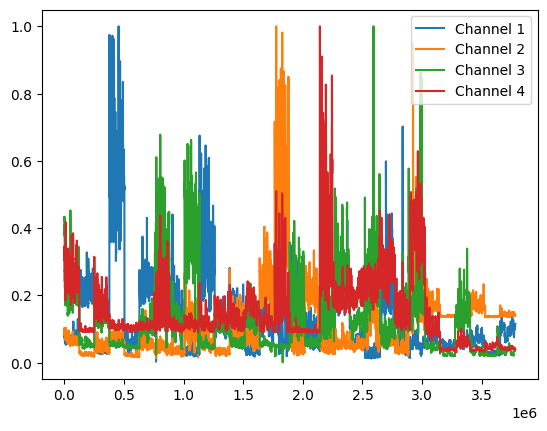

In [6]:
for d in range(n_channel):
    plt.plot(X.reshape(-1, 4)[:, d], label=f'Channel {d+1}')
plt.legend(ncol=1)

In [7]:
## 各モジュールの定義 
# Decoder  
# p(x|zx,zy,zd)
class px(nn.Module):
    def __init__(self, zd_dim, zx_dim, zy_dim, hidden_units, input_shape):
        super(px, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zd_dim + zx_dim + zy_dim, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3 = nn.Linear(hidden_units, input_shape)

    def forward(self, zd, zx, zy):
        zdzxzy = torch.cat([zd, zx, zy], dim=1)
        h = self.fc1(zdzxzy)
        h = self.fc2(h)
        rec_x = self.fc3(h)
        return rec_x 

# p(zd|d)
class pzd(nn.Module):
    def __init__(self, d_dim, zd_dim):
        super(pzd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(d_dim, zd_dim),
            nn.BatchNorm2d(zd_dim),
            nn.LeakyReLU()
        )
        self.fc2_mean = nn.Linear(zd_dim, zd_dim)
        self.fc2_logvar = nn.Sequential(nn.Linear(zd_dim, zd_dim, nn.Softplus()))
    
    def forward(self, d):
        h = self.fc1(d)
        zd_mean_prior = self.fc2_mean(h)
        zd_mean_prior = self.fc2_logvar(h) + + 1e-7
        return zd_mean_prior, zd_mean_prior
        
# p(zy|y)
class pzy(nn.Module):
    def __init__(self, y_dim, zy_dim):
        super(pzy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(y_dim, zy_dim),
            nn.BatchNorm2d(zy_dim),
            nn.LeakyReLU()
        )
        self.fc2_mean = nn.Linear(zy_dim, zy_dim)
        self.fc2_logvar = nn.Sequential(nn.Linear(zy_dim, zy_dim, nn.Softplus()))
    
    def forward(self, y):
        h = self.fc1(y)
        zy_mean_prior = self.fc2_mean(h)
        zy_logvar_prior = self.fc2_logvar(h) + 1e-7
        return zy_mean_prior, zy_logvar_prior

# Encoder
# q(zd|x)
class qzd(nn.Module):
    def __init__(self, input_shape, hidden_units, zd_dim):
        super(qzd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zd_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zd_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zd_mean = self.fc3_mean(h)
        zd_logvar = self.fc3_logvar(h) + 1e-7
        return zd_mean, zd_logvar

# q(zx|x)
class qzx(nn.Module):
    def __init__(self, input_shape, hidden_units, zx_dim):
        super(qzx, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zx_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zx_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zx_mean = self.fc3_mean(h)
        zx_logvar = self.fc3_logvar(h) + 1e-7
        return zx_mean, zx_logvar

# q(zy|x)
class qzy(nn.Module):
    def __init__(self, input_shape, hidden_units, zy_dim):
        super(qzy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zy_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zy_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zy_mean = self.fc3_mean(h)
        zy_logvar = self.fc3_logvar(h) + 1e-7
        return zy_mean, zy_logvar

# Auxiliary task
# q(d|zd)
class qd(nn.Module):
    def __init__(self, zd_dim, d_dim):
        super(qd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zd_dim, d_dim),
            nn.LeakyReLU()
        )
    
    def forward(self, zd):
        d_hat = self.fc1(zd)
        return d_hat

# q(y|zy)
class qy(nn.Module):
    def __init__(self, zy_dim, y_dim):
        super(qy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zy_dim, y_dim),
            nn.LeakyReLU()
        )
    
    def forward(self, zy):
        y_hat = self.fc1(zy)
        return y_hat

In [57]:
class DIVA(nn.Module):
    def __init__(self):
        super(DIVA, self).__init__()
        '''各zの次元数'''
        self.zd_dim = 2
        self.zx_dim = 2
        self.zy_dim = 2 
        '''被験者の数'''
        self.d_dim = 5
        '''クラス数'''
        self.y_dim = 6
        '''入力データの次元数'''
        self.input_shape = 45*4
        self.hidden_units = 256

        '''モジュールの定義'''
        self.px = px(zd_dim=self.zd_dim, zx_dim=self.zx_dim, zy_dim=self.zy_dim, hidden_units=self.hidden_units, input_shape=self.input_shape)

        self.pzd = pzd(d_dim=self.d_dim, zd_dim=self.zd_dim)
        self.pzy = pzy(y_dim=self.y_dim, zy_dim=self.zy_dim)

        self.qzd = qzd(input_shape=self.input_shape, hidden_units=self.hidden_units, zd_dim=self.zd_dim)
        self.qzx = qzx(input_shape=self.input_shape, hidden_units=self.hidden_units, zx_dim=self.zx_dim)
        self.qzy = qzy(input_shape=self.input_shape, hidden_units=self.hidden_units, zy_dim=self.zy_dim)

        self.qd = qd(zd_dim=self.zd_dim, d_dim=self.d_dim)
        self.qy = qy(zy_dim=self.zy_dim, y_dim=self.y_dim)
    
    def reparameterize(self, mean, logvar):
        '''Reparameterization trick'''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, d, x, y):
        '''Encoder'''
        zd_mean, zd_logvar = self.qzd(x)
        zd = self.reparameterize(zd_mean, zd_logvar)
        zx_mean, zx_logvar = self.qzx(x)
        zx = self.reparameterize(zx_mean, zx_logvar)
        zy_mean, zy_logvar = self.qzy(x)
        zy = self.reparameterize(zy_mean, zy_logvar)
        '''Decoder'''
        rec_x = self.px(zd, zx, zy)
        zd_mean_prior, zd_logvar_prior = self.pzd(d)
        zd_prior = self.reparameterize(zd_mean_prior, zd_logvar_prior)
        zy_mean_prior, zy_logvar_prior = self.pzy(y)
        zy_prior = self.reparameterize(zy_mean_prior, zy_logvar_prior)
        '''Auxiliary task'''
        d_hat = self.qd(zd)
        y_hat = self.qy(zy)
        return rec_x, d_hat, y_hat, zd, zx, zy, zd_prior, zy_prior
    
    def loss(self, d, x, y):
        

[]


In [ ]:
print(len(stacked_data))
print(len(class_label))
print(len(subject_label))

83999
83999
83999


In [ ]:
print(len(stacked_data))
print(len(class_label))
print(len(subject_label))

83999
83999
83999


In [49]:
print(stacked_data.shape)
print(class_label.shape)
print(subject_label.shape)
print(len(class_label[class_label==0]))

print(len(subject_label[subject_label==0]))

(83999, 45, 4)
(83999,)
(83999,)
13999
16799
